# --- CORRELATING (FLUX OF) SPOTS (FAKE STARS FROM SPOT PROJECTOR) WITH FLAT FIELDS ---

The spot projector is used is 2 ways:
        taking many images at one location on the sensor
        taking many images each at a different position on the sensor
            this type of data we have for one ITL and one E2V sensor 

Looking at the relative throughput of each pixel in the sensor, checking if it is the same when tested with the spot projector vs. flat fielding. Answers/confirms the preceding question of: does flat fielding correctly describe how QE varies per pixel per wavelength?? 

If there are variations in relative throughput between spots (for one sensor), this can tell us how much of the variation is due to the flux of the star/light source vs. due to the response of the CCD OR position of sensor/amplifier/pixel in the FOCAL PLANE! (QE can vary spatially depending on region of focal plane/sensor/amp)

Calibrate average flux value for spots and for CCOB flat. Divide each "star" and each CCOB flat pixel by the respective average flux value to get the CALIBRATED value of each "star"/flat pixel.

I will access Adam's code and pull flux data (with mean of flux of each star, one mean for each dither) and x,y position data to tell me where the star is on the grid. This mean flux is our "calibration" value, I can take the flux of each star and divide by the calibration value to get relative throughput for each "star" (RESIDUAL) and see how this varies with focal plane location, etc., then I can compare this calibrated value in a "star" region against the same positional region in the flat. It will be important to use code that conducts mapping between amp/ccd/focal plane coordinates.

(https://github.com/snyder18/mixcoatl)

#### "STARS" SHOULD IDEALLY SHOW THE SAME VARIATIONS THAT THE FLAT FIELDS DO!!

#### Yousuke's idea:

- Yes. the one Oscar is working but complimentary. I am not super clear yet but let me try to explain. As we don't know how the QE variation affects in science product, investigating the correlation between QE variation -- flat with spot is interesting. Thinking about the spot, you have measurements of flux (zero-th), positions (1st), and shape (2nd moments). So you can correlate those measurements with QE variations. Suppose we are going to compare flux f a function of positions against QE variation Q (as a function of positions), we can calculate correlation coefficient r =<df dQ>/(<df^2><dQ^2>) using deviations df, dQ from mean numbers <f>, <Q> . 
- If there is the correlation, r will be a non-zero value and vice versa. You could repeat this analysis with positional differences from fiducial as a function of positions, shapes as a function of positions.
But what I am not clear is how we say whether if it is significant or not. We should evaluate noise level in r but I haven't had a clear view how we evaluate noise level, but eventually I'll come up with some idea hopefully? Probably we could use typical methods -- bootstrap or jackknife but I am not super clear. 

In [1]:
# all 1400? position data filed located in spotdata directory
# referencing Adam's code on git to utilize data, changing it to measure flux though (not centroid)

# NaN : not a number, a value in an array such as 0/0 is NaN
# masked array : missing data values

In [2]:
# sourceGridTask.py imports functions in sourcegrid.py

"""
import os
import numpy as np
from os.path import join, splitext
import scipy
from scipy.spatial import distance
from astropy.io import fits
import lsst.pex.config as pexConfig
import lsst.pipe.base as pipeBase
from lsst.obs.lsst import LsstCamMapper as camMapper
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms
"""

from sourcegrid import BaseGrid, DistortedGrid, grid_fit, coordinate_distances
from sourceGridTask import SourceGridConfig, SourceGridTask

### I'll want to build a "calibration" file, holding the mean flux for each artificial star.  Adam has something similar now for the centroid - thats the gX and gY in the code I think. You’ll need to make mean flux values and subtract those off when calculating dflux_array.


From Adam's notebook:

In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob

%matplotlib inline

In [4]:
## Example processed grid, all of these files are located in my directory: spotdata
## 3rd file down, testing ONE DITHER (position) AT A TIME RIGHT NOW
infile = '/home/lpayne22/spotdata/MC_C_20191030_000363_R22_S11_15.0s_0.1x_-3.5y_processed_grid.fits'
infile2 = '/home/lpayne22/spotdata/MC_C_20191030_000364_R22_S11_15.0s_-2.7x_-3.9y_processed_grid.fits'

In [5]:
## Open as a FITs table with all of spot data using Astropy
hdul = fits.open(infile)
hdul2 = fits.open(infile2)

## Print Main Header
print('Main Header\n')
print(repr(hdul[0].header))


## Print Table Header
print('\nTable Header\n')
print(repr(hdul[1].header))

Main Header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
X0      =    2385.220108337066                                                  
Y0      =    1996.675045679444                                                  
XSTEP   =    65.34408630180397                                                  
YSTEP   =    65.35191691653706                                                  
THETA   = -0.05426371615038783                                                  
NCOLS   =                   49                                                  
NROWS   =                   49                                                  

Table Header

XTENSION= 'BINTABLE'           / binary table extension                         


### Residual Widths of Fake Stars

### Showing star flat (made from spot projector) calibrated beam response (QE/throughput), will compare to CCOB flat

Text(0.5, 1.0, 'Fake Star Calibrated Flux')

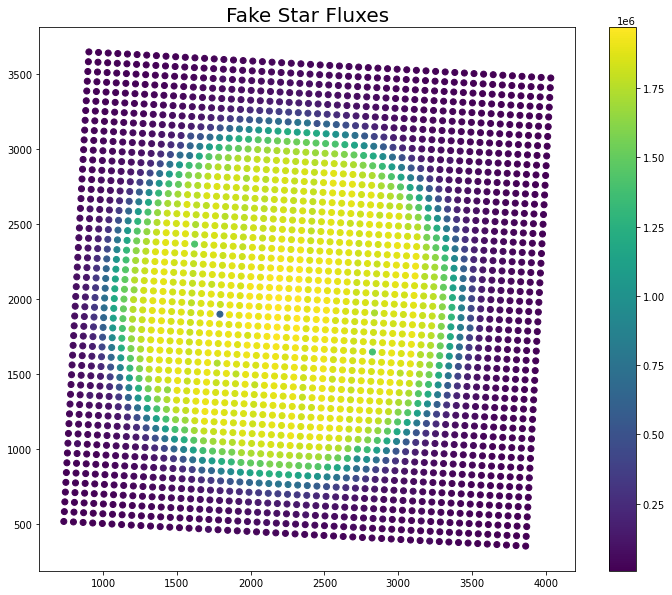

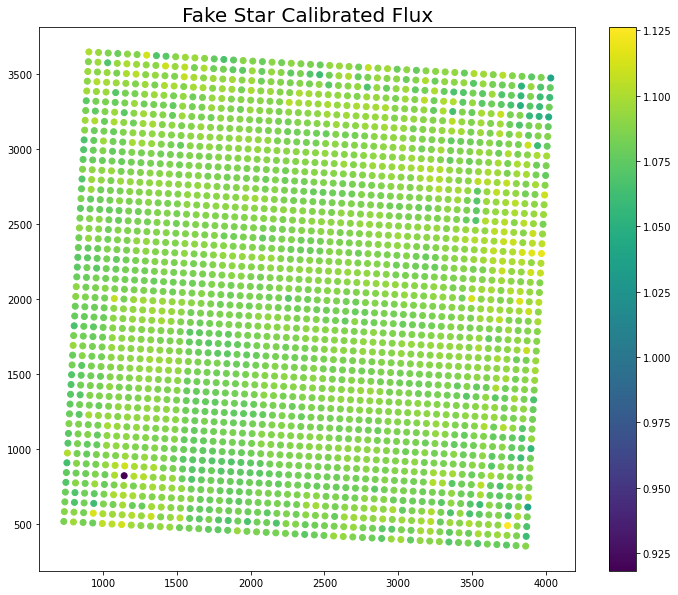

In [6]:
import pylab

## Get Data table
data = hdul[1].data

## Get fake stars' x/y positions and flux value
x = data['X']
y = data['Y']
flux = data['FLUX']

## For each star its uncalibrated flux is plotted at its respective grid coordinate 
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
im = ax.scatter(x, y, c=flux)


fig.colorbar(im)
ax.set_title('Fake Star Fluxes', fontsize=20)


# # # # # # # # # # # # # # # # # # # # # # # # # # # 


# Now look at the flux residuals 
## These are the changes to the fake star moments from the above mean in this particular image.
### flux ratio: calibrated flux value at each star (flux of each star / flux of the star averaged over all dithers, already calculated)
dflux = data['dFLUX']    # mean?
residual_flux = (flux + dflux) / flux

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
im = ax.scatter(x, y, c=residual_flux)

fig.colorbar(im, cmap=pylab.get_cmap("binary"))
ax.set_title('Fake Star Calibrated Flux', fontsize=20)

Text(0.5, 1.0, 'Fake Star Calibrated Flux')

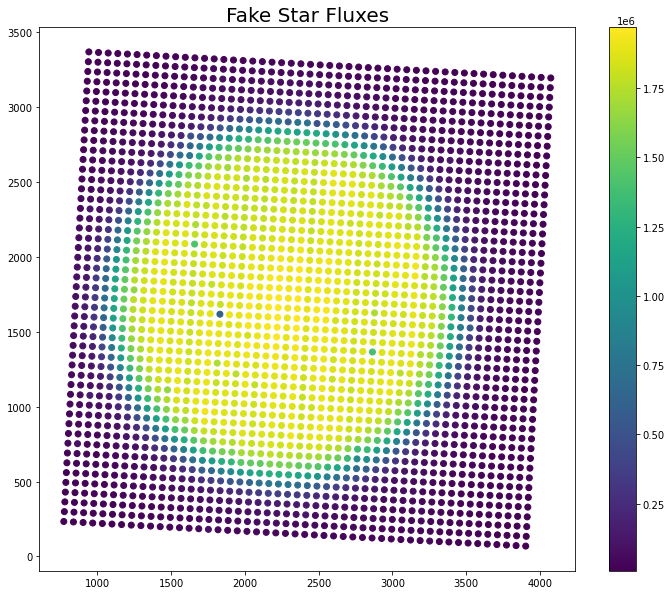

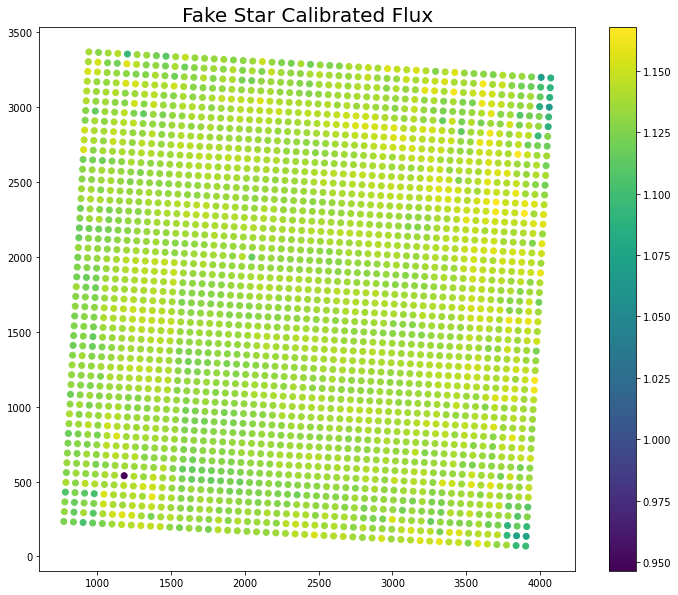

In [7]:
data = hdul2[1].data

## Get fake stars' x/y positions and flux value
x2 = data['X']
y2 = data['Y']
flux2 = data['FLUX']

## For each star its uncalibrated flux is plotted at its respective grid coordinate 
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
im2 = ax.scatter(x2, y2, c=flux2)


fig.colorbar(im2)
ax.set_title('Fake Star Fluxes', fontsize=20)


# # # # # # # # # # # # # # # # # # # # # # # # # # # 


# Now look at the flux residuals 
## These are the changes to the fake star moments from the above mean in this particular image.
### flux ratio: calibrated flux value at each star (flux of each star / flux of the star averaged over all dithers, already calculated)
dflux2 = data['dFLUX']    # mean?
residual_flux2 = (flux2 + dflux2) / flux2

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
im2 = ax.scatter(x2, y2, c=residual_flux2, cmap=None)

fig.colorbar(im2)
ax.set_title('Fake Star Calibrated Flux', fontsize=20)
#cmap=pylab.get_cmap("binary") or cmap=plt.cm.gray not working ?

Text(0.5, 1.0, 'Ratio of 2 Fake Star Calibrated Fluxes')

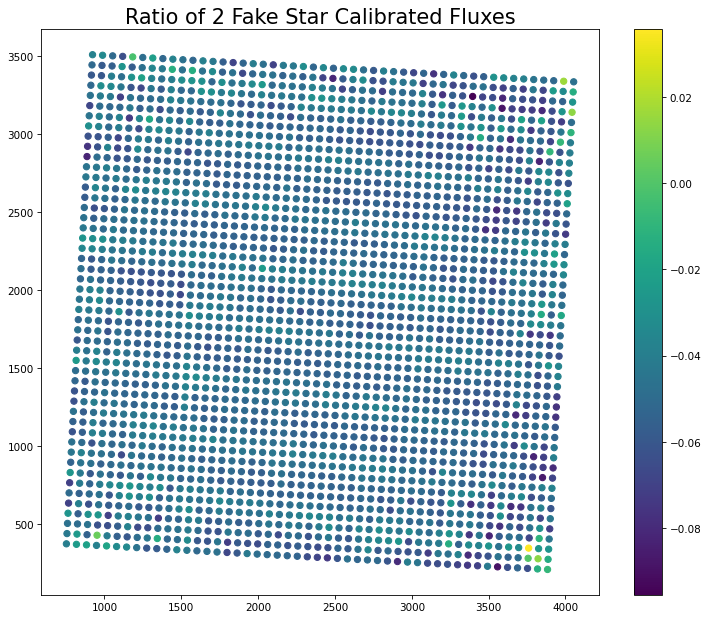

In [8]:
#### residual of calibrated fluxes between 2 adjacent dithers ####

x_avg = (x + x2) / 2
y_avg = (y + y2) / 2

residual_flux_rat = (residual_flux - residual_flux2) 

fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=75)
im_rat = ax.scatter(x_avg, y_avg, c=residual_flux_rat)

fig.colorbar(im_rat)
ax.set_title('Ratio of 2 Fake Star Calibrated Fluxes', fontsize=20)


### Looping over ALL dithers and plotting calibrated flux, reconstructing a filled-in grid

In [9]:
import os

directory = os.fsencode('/home/lpayne22/spotdata')
dither_files = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith("_processed_grid.fits"): 
         # print(os.path.join(directory, filename))
        dither_files.append(filename)

print(len(dither_files))

1600


### We are studying the effect of focal plane location on relative throughput

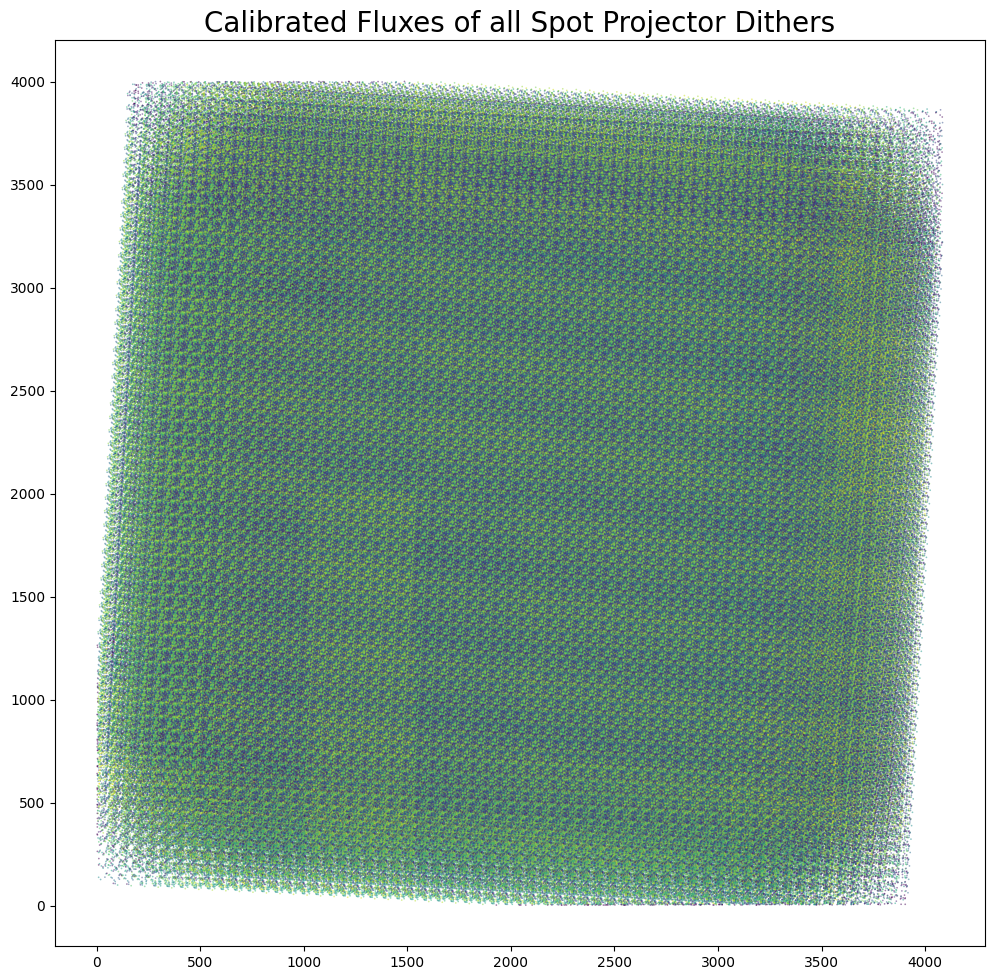

In [10]:
data_list = []
infile_list = []
for file in dither_files:   
    file_str = '/home/lpayne22/spotdata/' + str(file)
    infile_list.append(file_str)     # list of FULL file paths, dither_files just has working directory
    hdul = fits.open(file_str)
    data = hdul[1].data
    data_list.append(data)

fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi=100)
ax.set_title('Calibrated Fluxes of all Spot Projector Dithers', fontsize=20)

for i in range(len(dither_files)):
    x = data_list[i]['X']
    y = data_list[i]['Y']
    flux = data_list[i]['FLUX']
    dflux = data_list[i]['dFLUX']
    residual_flux = (flux + dflux) / flux
    
    im = ax.scatter(x, y, s=1.5, c=residual_flux, alpha=0.5, edgecolors='none')
    
#fig.colorbar(im)
plt.show()


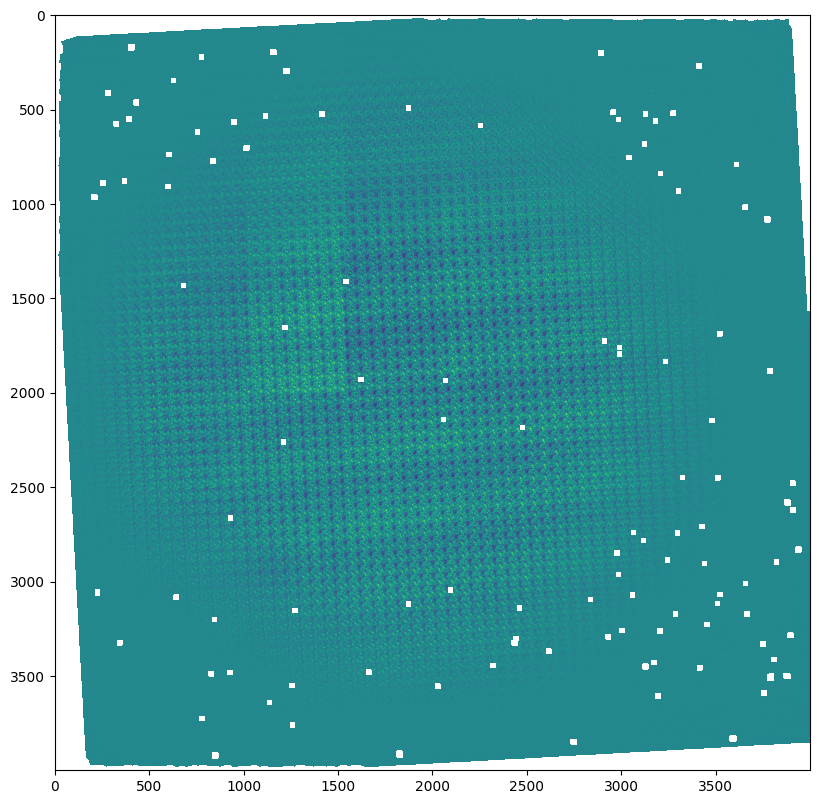

In [20]:
from make_distortion_images import main
sensor_id = 'R22_S11'

image_array = main(sensor_id, infile_list, output_dir='/home/lpayne22/WORK', do_smoothing=True)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(image_array)